In [782]:
# CMPS140 Project - How to Become Top Earner in Airbnb?
# Tangni Wang, Tung Hoi Man, Yunxiang Fu
# {twang63, tuman, yfu7}@ucsc.edu

In [783]:
# To do:

# Split Training set, testing set in code?
# Convert attributes to numbers
# Generate graph
# Different model with different functions? Which function do we use?


In [784]:
import warnings
warnings.simplefilter("ignore")

import sklearn # sci-kit learn
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

In [785]:
# Helper functions
def correction(x):
    '''
    Columns value corrections
    '''
    if type(x)==str:
        x=x.replace('$','')
        x=x.replace(',','')
        x=float(x)    
    return (x)

def correction2(x):
    '''
    Columns value corrections
    '''
    if type(x)==str:
        x=x.replace('%','')
        x=float(x)/100.0
    return (x)

def to_int(x):
    '''
    Columns value corrections
    '''
    if x=='f':
        x=x.replace('f','0')
    elif x=='t':
        x=x.replace('t','1')
    else:
        x= '0'
    return int(x)

# def changeTime(x):
#     '''
#     change host_response_time columns from string into numerical.
#     '''
#     if x == 'within an hour':
#         x=x.replace('within an hour', '1')
#     elif x == 'within a few hours':
#         x=x.replace('within a few hours', '4')
#     elif x == 'within a day':
#         x=x.replace('within a day', '24')
#     elif x == 'a few days or more':
#         x=x.replace('a few days or more', '48')
#     else:
#         x='96'
        
#     return int(x)

def changeTime(x):
    '''
    change host_response_time columns from string into numerical.
    '''
    if x == 'within an hour':
        x='1'
    elif x == 'within a few hours':
        x='4'
    elif x == 'within a day':
        x='24'
    elif x == 'a few days or more':
        x='48'
    else:
        x='96'
        
    return x

def convertPolicy(x):
    '''
    Convert cancellation_policy columns from string into numerical.
    '''
    if x == 'strict':
        x=x.replace('strict', '1')
    elif x == 'moderate':
        x=x.replace('moderate', '3')
    elif x == 'flexible':
        x=x.replace('flexible', '5')
    else:
        x='3'
        
    return int(x)

In [786]:
# Parsing csv file
seattle_file_path = 'seattle_data/listings.csv'
seattle_data = pd.read_csv(seattle_file_path)
# seattle_data.columns

In [787]:
# Make a new attribute for prediction
seattle_data['new_score_reviews'] = seattle_data['reviews_per_month'] * seattle_data['review_scores_rating'] / 10
# seattle_data.describe()
# seattle_data

In [788]:
# Define top performers and low performers
top90flag = seattle_data['new_score_reviews'].quantile(0.9)
upto25flag = seattle_data['new_score_reviews'].quantile(0.25)

seattle_data['top90'] = seattle_data.new_score_reviews >= top90flag
seattle_data['upto25'] = seattle_data.new_score_reviews <= upto25flag

print('The boundaries of top performer listings:', top90flag)
print('The boundaries of low performer listings:', upto25flag)

The boundaries of top performer listings: 44.109
The boundaries of low performer listings: 6.480000000000001


In [789]:
# Data Processing

# Drop useless columns
useless_colmuns = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description',
    'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
    'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
    'host_response_rate', 'host_acceptance_rate', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
    'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'street', 
    'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'market',
    'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 
    'room_type', 'bed_type', 'amenities', 'square_feet', 'guests_included', 'maximum_nights', 'calendar_updated', 
    'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 
    'calendar_last_scraped', 'number_of_reviews', 'first_review', 'last_review', 'review_scores_accuracy', 
    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
    'review_scores_value', 'requires_license', 'license', 'jurisdiction_names', 'require_guest_profile_picture', 
    'require_guest_phone_verification', 'calculated_host_listings_count', 'review_scores_rating', 'reviews_per_month'
]
seattle_data.drop(useless_colmuns, axis=1)

# Remove $: price, weekly_price, security_deposit, extra_people, cleaning_fee
seattle_data['price']=seattle_data['price'].map(lambda x: correction(x))
seattle_data['weekly_price'] = seattle_data['weekly_price'].map(lambda x: correction(x))
seattle_data['monthly_price'] = seattle_data['monthly_price'].map(lambda x: correction(x))
seattle_data['security_deposit'] = seattle_data['security_deposit'].map(lambda x: correction(x))
seattle_data['extra_people'] = seattle_data['extra_people'].map(lambda x: correction(x))
seattle_data['cleaning_fee'] = seattle_data['cleaning_fee'].map(lambda x: correction(x))

# Convert string to number: host_response_time, cancellation_policy
seattle_data['host_response_time'] = seattle_data['host_response_time'].apply(changeTime).astype(int)
seattle_data['cancellation_policy'] = seattle_data['cancellation_policy'].map(lambda x: convertPolicy(x))

# Convert boolean t/f to int 1/0: host_is_superhost, host_identity_verified, instant_bookable
for i in seattle_data.columns:
    
    if set(seattle_data[i])=={'t','f'}:
        seattle_data[i]=seattle_data[i].apply(to_int)
        
    elif set(seattle_data[i]) == {'t','f',np.nan}:
        seattle_data[i]=seattle_data[i].apply(to_int)

# Fill missing value with reasonable values like 0 or 1.
seattle_data['new_score_reviews'].fillna(0, inplace = True)
seattle_data['accommodates'].fillna(0, inplace = True)
seattle_data['bathrooms'].fillna(0, inplace = True)
seattle_data['beds'].fillna(0, inplace = True)
seattle_data['price'].fillna(0, inplace = True)
seattle_data['weekly_price'].fillna(0, inplace = True)
seattle_data['monthly_price'].fillna(0, inplace = True)
seattle_data['security_deposit'].fillna(0, inplace = True)
seattle_data['cleaning_fee'].fillna(0, inplace = True)
seattle_data['extra_people'].fillna(0, inplace = True)
seattle_data['minimum_nights'].fillna(1, inplace = True)

# Relevant Features
seattle_features = ['zipcode', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'weekly_price', 
                    'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people', 'minimum_nights', 
                    'host_response_time', 'host_is_superhost', 'host_identity_verified', 'instant_bookable', 
                    'cancellation_policy', 'new_score_reviews' 
                    ]

# Drop rows if any feature still has missing value
seattle_data = seattle_data[seattle_features].dropna()

# print(seattle_data[seattle_features])

In [790]:
# Needed features:
# X is the independent variable
features = ['zipcode', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'weekly_price', 
                    'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people', 'minimum_nights', 
                    'host_response_time', 'host_is_superhost', 'host_identity_verified', 'instant_bookable', 
                    'cancellation_policy'
                    ]

X = seattle_data[features]

# Statistic of seattle features
# X
# X.describe()

In [791]:
# Prediction target, dependent variable
y = seattle_data.new_score_reviews
# y
# y.describe()

In [792]:
'''
The pairs plot builds on two basic figures, the histogram and the scatter plot. 
The histogram on the diagonal allows us to see the distribution of a single variable 
while the scatter plots on the upper and lower triangles show the relationship (or lack thereof) 
between two variables.
'''
# sns.pairplot(seattle_data)

'\nThe pairs plot builds on two basic figures, the histogram and the scatter plot. \nThe histogram on the diagonal allows us to see the distribution of a single variable \nwhile the scatter plots on the upper and lower triangles show the relationship (or lack thereof) \nbetween two variables.\n'

In [793]:
'''
A histogram divides the variable into bins, counts the data points in each bin, 
and shows the bins on the x-axis and the counts on the y-axis.
'''
# sns.distplot(y)

'\nA histogram divides the variable into bins, counts the data points in each bin, \nand shows the bins on the x-axis and the counts on the y-axis.\n'

In [794]:
# Correlation
'''
The correlation coefficient, or simply the correlation, is an index that ranges from -1 to 1. 
When the value is near zero, there is no linear relationship. 
As the correlation gets closer to plus or minus one, the relationship is stronger. 
A value of one (or negative one) indicates a perfect linear relationship between two variables.
'''
# result: 
# stronger correlation: host_is_superhost, instant_bookable, host_response_time, bedrooms, price, cleaning fee
# weaker corr: accommodates, beds, bathrooms, host_identity_verified
# almost no corr: zipcode, weekly_price, monthly_price, security_deposit, extra_people

# seattle_data.corr()

'\nThe correlation coefficient, or simply the correlation, is an index that ranges from -1 to 1. \nWhen the value is near zero, there is no linear relationship. \nAs the correlation gets closer to plus or minus one, the relationship is stronger. \nA value of one (or negative one) indicates a perfect linear relationship between two variables.\n'

In [795]:
# Split training and testing set. Training = 80%. Testing = 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3044, 17) (3044,)
(761, 17) (761,)


In [807]:
# Baseline model
# Make prediction by mean or median
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).

from sklearn.dummy import DummyRegressor
# from sklearn.metrics import r2_score

# Create a dummy regressor
baseline_model = DummyRegressor(strategy='mean')

# "Train" dummy regressor
baseline_model.fit(X_train, y_train)
# print(dummy_mean)

# Predict
# print("Baseline model predicitions using testing set ")
# print(X2.head())
# print("The predictions are:")
# y_pred_bm = baseline_model.predict(X_test)
print("The score is:")
print(baseline_model.score(X_test, y_test))
# r2_score(y_test, y_pred_bm)

The score is:
-3.2520698378668556e-06


Text(0, 0.5, 'Predictions (y_pred_lm)')

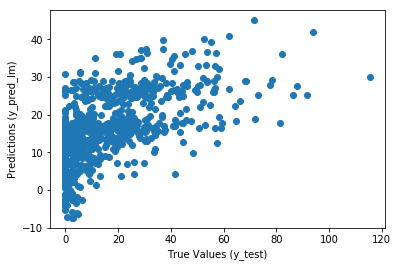

In [808]:
# Linear Regression
lin_model = linear_model.LinearRegression()
lin_model = lin_model.fit(X_train, y_train)
y_pred_lm = lin_model.predict(X_test)

plt.scatter(y_test, y_pred_lm)
plt.xlabel("True Values (y_test)")
plt.ylabel("Predictions (y_pred_lm)")

In [809]:
print("lin_model score:", lin_model.score(X_test, y_test))
# The mean absolute error (mae)
print("lin_model mae:", mean_absolute_error(y_pred_lm, y_test))

lin_model score: 0.3223501586770844
lin_model mae: 10.661385130886293


In [810]:
# The coefficients
print('Coefficients: \n', lin_model.coef_)
# The mean squared error (mse)
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction, same as score
print('Variance score (same as score): %.3f' % r2_score(y_test, y_pred))

Coefficients: 
 [-1.60501238e-02  9.59663259e-01  7.59530190e-02 -1.99980604e+00
 -1.03277111e-01 -1.20640722e-02  6.09900969e-04  2.14805937e-04
 -2.10722857e-03 -7.07223764e-02  4.66326070e-02 -1.61309119e-02
 -1.16148260e-01  1.04866759e+01  2.36693767e+00  9.50549861e+00
 -7.49124008e-01]
Mean squared error: 213.63
Variance score (same as score): 0.322


In [811]:
# # Ridge Regression with built-in cross-validation of the alpha parameter.
# ridgecv_model = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0], cv=6, fit_intercept=True, scoring=None,
#     normalize=False)
# ridgecv_model.fit(X_train, y_train)
# # ridgecv_model.alpha_

# y_pred_rcv = ridgecv_model.predict(X_test)

# plt.scatter(y_test, y_pred_rcv)
# plt.xlabel("True Values (y_test)")
# plt.ylabel("Predictions (y_pred_rcv)")
# print("ridgecv_model score:", ridgecv_model.score(X_test, y_test))
# print("ridgecv_model mae:", mean_absolute_error(y_pred_rcv, y_test))

Text(0, 0.5, 'Predictions (y_pred_ridge)')

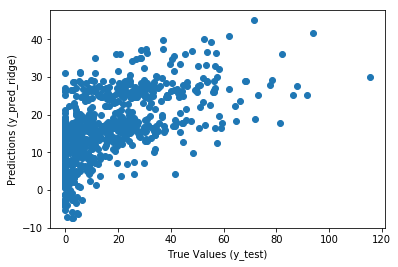

In [812]:
# Ridge Regression
ridge_model = linear_model.Ridge(alpha=.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
ridge_model.fit(X_train, y_train)
# reg.coef_
# reg.intercept_
y_pred_ridge = ridge_model.predict(X_test)

plt.scatter(y_test, y_pred_ridge)
plt.xlabel("True Values (y_test)")
plt.ylabel("Predictions (y_pred_ridge)")

In [813]:
print("ridge_model score:", ridge_model.score(X_test, y_test))
print("ridge_model mae:", mean_absolute_error(y_pred_ridge, y_test))

ridge_model score: 0.32230821067246496
ridge_model mae: 10.661743095356572


Cross-validated scores: [ 0.25070165  0.2813271   0.26080599  0.26064496 -1.60934324  0.34368981]
Cross-Predicted Accuracy: 0.31642460230195846


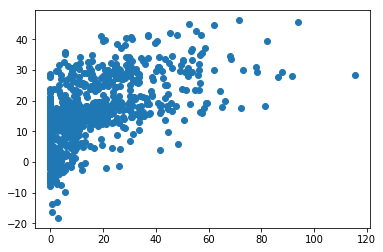

In [804]:
# Perform 6-fold cross validation (cv)

scores = cross_val_score(lin_model, X, y, cv=6)
print("Cross-validated scores:", scores)

# As you can see, the last fold improved the score of the original model — from 0.322 to 0.343

# Make cross validated predictions
y_pred_cvp = cross_val_predict(lin_model, X_test, y_test, cv=6)
plt.scatter(y_test, y_pred_cvp)

# Cross-Predicted Accuracy, r2_score
accuracy = metrics.r2_score(y_test, y_pred_cvp)
print("Cross-Predicted Accuracy:", accuracy)

Text(0, 0.5, 'Predictions (y_pred_lasso)')

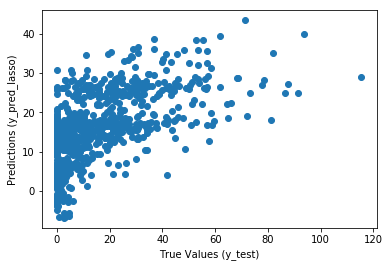

In [805]:
# Lasso Regression
lasso_model = linear_model.Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

plt.scatter(y_test, y_pred_lasso)
plt.xlabel("True Values (y_test)")
plt.ylabel("Predictions (y_pred_lasso)")

In [806]:
print("lasso_model score:", lasso_model.score(X_test, y_test))
print("lasso_model mae:", mean_absolute_error(y_pred_lasso, y_test))

lasso_model score: 0.31782773995165603
lasso_model mae: 10.6980250128968
